In [1]:
import pandas as pd

In [88]:
df = pd.read_csv('BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Exploring The text data

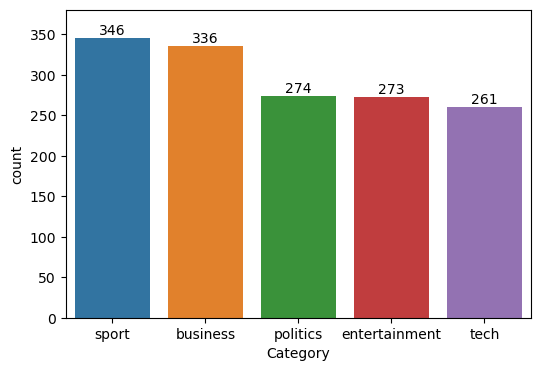

In [89]:
categories = df.Category.value_counts().to_frame().reset_index().set_axis(['Category', 'count'], axis= 1)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=categories['Category'], y=categories['count'], ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.show()

In [90]:
# Remove duplicates
with_duplicates = df.shape[0]
df = df.drop_duplicates(subset='Text')
without_duplicates = df.shape[0]

In [91]:
print('Removed {} duplicate rows'.format(with_duplicates-without_duplicates))

Removed 50 duplicate rows


### Preprocessor

- To convert the text to TFIDF matrix
- This will then be exposed to classification techiques

In [92]:
#importing nltk library components for preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [106]:
def text_cleaner(text):
    # Removing unwanted text:
    # Replace digits and single letters
    pattern = r'\b([a-zA-Z])\b|\d+|[.,!?()-\:]'
    text = re.sub(pattern, '', text)

    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    ps = PorterStemmer()
    tokens_stemmed = [ps.stem(word) for word in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # print("Tokens:", tokens)
    # print("Stemmed Tokens:", tokens_stemmed)
    # print("Lemmatized Tokens:", tokens_lemmatized)
    text = ' '.join(tokens_lemmatized)
    return text

# def text_cleaner(df_to_clean):
#     for i,text in enumerate (df_to_clean['Text']):
#         df_to_clean['Text'][i] = text_cleaning_string(text)
#     print(df_to_clean)
#     return df_to_clean


In [107]:
# Clean the DF texts completely
# To be applied to test data also

df['Text'] = text_cleaner(df)

TypeError: expected string or bytes-like object

In [108]:
train_df = pd.read_csv('BBC News Train.csv').drop_duplicates(subset='Text')
test_df = pd.read_csv('BBC News Test.csv') 

from sklearn.model_selection import train_test_split 
train_df, crossval_df = train_test_split(train_df,stratify=train_df[['Category']],test_size=0.2,random_state = 310)

In [109]:
crossval_df.shape

(288, 3)

#### Build a class to preprocess data and compute vectorizeed matrix representing word counts with tf-idf
- A class is created to save generate vectorized matrix for train, cross validation and test sets. This class also contains some helper functions for plotting, fitting, and predicting.

In [110]:
from sklearn import metrics
class MyData(object):
    """
    Represent text data as a sparse matrix with TfidfVectorizer
    Note: This class does not follow sklearn syntax. 
    """
    def __init__(self,df,TfidfVec=None,clean_text=True,**TtdifVec_kwargs):
        """
        Inputs:
        -df: a DataFrame including column "Text"
        -TfidfVec: previously fitted TfidfVectorizer object (pass None for a new fit)        
        -clean_text: if True, 'Text' column will be cleaned.
        -TtdifVec_kwargs: parameters to pass when the TfidfVectorizer is created
        Fields:
        -MyData.words: list of words used by TfidfVec
        -MyData.tv: fitted TfidfVectorizer object
        -MyData.WC2: Sparse matrix representation of the text
        """
        self.df = df.copy()
        if clean_text:
            self.clean_text()
        self.get_WC2(TfidfVec,**TtdifVec_kwargs)
    def clean_text(self):
        for i,text in enumerate (self.df['Text']):
            self.df['Text'][i] = text_cleaner(text)
    def get_WC2(self,TfidfVec=None,**TtdifVec_kwargs):
        """
        Fit TfidfVectorizer to text and return a sparse matrix from tf-idf
        """
        if TfidfVec is None:
            # This is fit only done with the training data set.
            if len(TtdifVec_kwargs)==0:
                # Fit with default parameters
                self.tv = TfidfVectorizer(min_df=0.004,max_df=0.417)  
            else:
                # Fit with user defined parameters
                self.tv = TfidfVectorizer(**TtdifVec_kwargs)
                
            self.WC2 = self.tv.fit_transform(self.df['Text'])
        else:
            # The user passed the training TfidfVectorizer object
            self.tv = TfidfVec  
            self.WC2 = self.tv.transform(self.df['Text'])
        self.words = self.tv.get_feature_names_out()                   
 
    def get_WC2_as_df(self):
        """Converts the sparse matrix WC2 into a full DataFrame"""
        return pd.DataFrame(self.WC2.A,columns=self.words)
    def __repr__(self):
        return "MyData( nwords={} )".format(self.WC2.shape)
    def __str__(self):
        return  self.__repr__()

    @staticmethod
    def plot_confusion_matrix(y_true,y_pred,title='Confusion Matrix'):        
        labels = list(set(y_pred).union(set(y_true)))        
        cm = metrics.confusion_matrix(y_true,y_pred,labels=labels)
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='g',ax=ax);
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title(title); 
        ax.xaxis.set_ticklabels(labels); ax.ya

In [111]:
train_data = MyData(train_df)
crossval_data = MyData(crossval_df,train_data.tv)
test_data = MyData(test_df,train_data.tv)
print('WC2 in training data set has size:',train_data.WC2.shape)
print('WC2 in crossval_data data set has size:',crossval_data.WC2.shape)
print('WC2 in test_data data set has size:',test_data.WC2.shape)

/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_2851/2594895985.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Text'][i] = text_cleaner(text)
/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_2851/2594895985.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Text'][i] = text_cleaner(text)
/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_2851/2594895985.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

WC2 in training data set has size: (1152, 6127)
WC2 in crossval_data data set has size: (288, 6127)
WC2 in test_data data set has size: (735, 6127)
